In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#create a class
class EspressoRun :
    def __init__(self,filename) :
        assert type(filename) == str
        self.df = pd.read_csv(filename, comment='#', header=0)
        #if Parent is null for BODY section it means the function was called in main
        self.df.ix[ pd.isnull(self.df.Parent) & (self.df.Section == "BODY"), 'Parent' ] = 'main'
    
    def computeParentPercent(self):
        asd = self.df.groupby(['Parent','Section']).aggregate(sum)
        asd = self.df[self.df.Section == "BODY"].groupby('Parent').aggregate(sum)
        asd.rename(columns={'cpuTime':'parentCpuTime','wallTime':'parentWallTime','Calls':'parentCalls'},inplace=True)

        self.df = pd.merge(self.df , asd , how='left', right_index=True, left_on='Parent')

        self.df['wallTime_parentPercent']=np.nan
        self.df['cpuTime_parentPercent']=np.nan
        self.df['calls_parentPercent']=np.nan

        self.df.cpuTime_parentPercent = self.df.cpuTime / self.df.parentCpuTime * 100
        self.df.wallTime_parentPercent = self.df.wallTime / self.df.parentWallTime * 100
        self.df.calls_parentPercent = self.df.Calls / self.df.parentCalls * 100
    
    def getParentDatas(self,parent) :
        return self.df[ self.df.Parent == parent]
        
    def getPieOfParent(self,parent,metric ='cpuTime_parentPercent'):
        toPlot = self.getParentDatas(parent)[['name',metric]].set_index('name') 
        plt.figure(figsize=(6,6))
        return plt.pie(toPlot,labels = toPlot.index,startangle=90)
    
    def getBodyFigure(self) :
        datas = self.df
        theParents = datas[datas.Section == "BODY"].Parent.unique()
        subplotGridHight = len(theParents)/2 + len(theParents)%2
        fig = plt.figure(figsize=(18,18))
        k = 0
        h = 0
        fig.suptitle("Profiling", fontsize=14, fontweight='bold')
        for parent in theParents:
            #print parent
            #print k,h
            ax = plt.subplot2grid((subplotGridHight,2), (k,h))
            h = (h+1)%2
            if h%2 == 0 : k = k+1

            toBarPlot = datas[(datas.Parent == parent) & (datas.Section == "BODY")][['name','Parent','cpuTime_parentPercent','wallTime_parentPercent','calls_parentPercent']]

            #sort by most cpu demanding
            toBarPlot.sort_values('cpuTime_parentPercent',ascending = False, inplace=True)

            cpuOffsets = [0]
            wallOffsets = [0]
            callsOffsets = [0]
            for i,j,z in zip(toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent) :
                cpuOffsets.append(cpuOffsets[len(cpuOffsets)-1] + i)
                wallOffsets.append(wallOffsets[len(wallOffsets)-1] + j)
                callsOffsets.append(callsOffsets[len(callsOffsets)-1] + z)
            cpuOffsets = cpuOffsets[:-1]
            wallOffsets = wallOffsets[:-1]
            callsOffsets = callsOffsets[:-1]

            cmap = plt.cm.jet
            zipped = zip(toBarPlot['name'],
                         toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent,
                         cpuOffsets,wallOffsets,callsOffsets,
                         range(0,len(toBarPlot['name'])))
            #print in reverse order because we wnat the bottom stack to be the least in the legend
            #unfortunately managing the legend order is not so easy
            for name,cpu,wall,calls,cpuO,wallO,callsO,nth in reversed(zipped):
                plt.bar([1,3,5], #position of the bar
                       [cpu,wall,calls],#height
                       width=1,
                       bottom=[cpuO,wallO,callsO],
                        color = cmap(1- (float(nth)/len(toBarPlot['name']))),
                        label = name 
                      )

            plt.xlim(0,10)
            plt.ylim(0,110)
            plt.title(parent)
            plt.xticks([1.5,3.5,5.5],['cpu time','wall time','calls'])
            plt.legend()
        return fig
    
    def getGlobalStackedPlot(self) :
        return self.df[['name','cpuTime','wallTime']].set_index('name').plot(kind='bar',figsize=(10,6))


In [77]:
#datas = pd.read_csv('Co3O4-H2-conf1-scf.csv', skiprows=3,header=0)
#datas = pd.read_csv('FIrpic_md_step_10000.csv', skiprows=3,header=0)
experiment8 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_8_8.csv')
experiment8.computeParentPercent()
#experiment.getPieOfParent("electrons","calls_parentPercent")
#asd = experiment.getBodyFigure()
#asd = experiment.getGlobalStackedPlot()

experiment16 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_16_16.csv')
experiment16.computeParentPercent()


experiment1 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_1_1.csv')
experiment1.computeParentPercent()
experiment4 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_4_4.csv')
experiment4.computeParentPercent()
experiment2 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_2_2.csv')
experiment2.computeParentPercent()




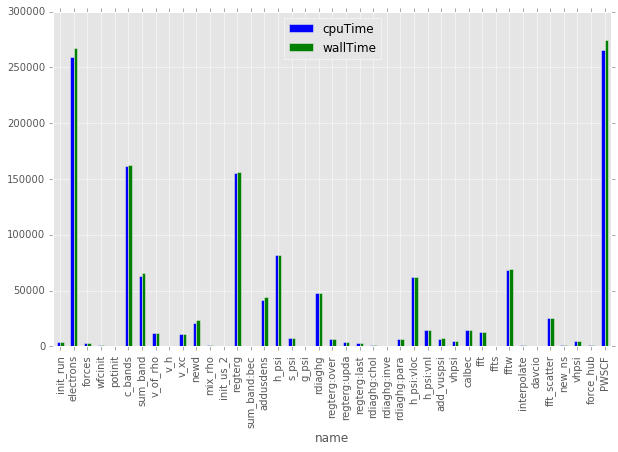

In [78]:
experiment8.getGlobalStackedPlot()

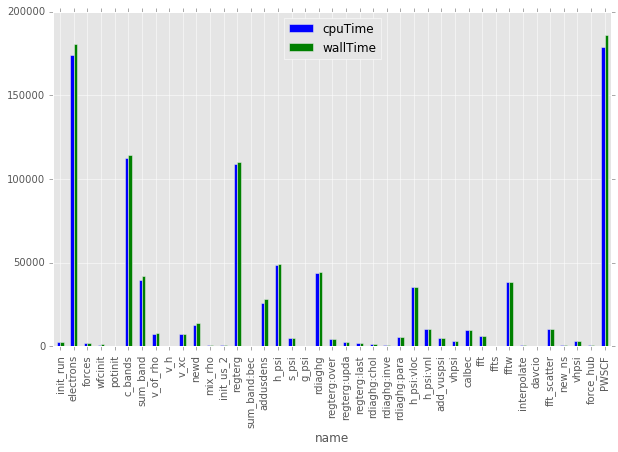

In [79]:
experiment16.getGlobalStackedPlot()

In [110]:
#all the elements in exp8 but not in exp 4
missing4 = experiment8.df.name[  experiment8.df.name.isin(experiment4.df.name) == False].index.values

exp4_yfill=list(experiment4.df.cpuTime.values)
exp2_yfill=list(experiment2.df.cpuTime.values)
exp1_yfill=list(experiment1.df.cpuTime.values)
#exp4_yfill.insert()
#experiment2.df.name[ experiment2.df.name.isin(experiment1.df.name) == False ]


for i in missing4 :
    exp4_yfill.insert(i,0)
    exp2_yfill.insert(i,0)
    exp1_yfill.insert(i,0)
    
#exp4_yfill

In [108]:
 experiment2.df.name[  experiment2.df.name.isin(experiment1.df.name) == False].index.values


array([], dtype=int64)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80]


([<matplotlib.axis.XTick at 0x7f47f566a550>,
 <a list of 5 Text yticklabel objects>)

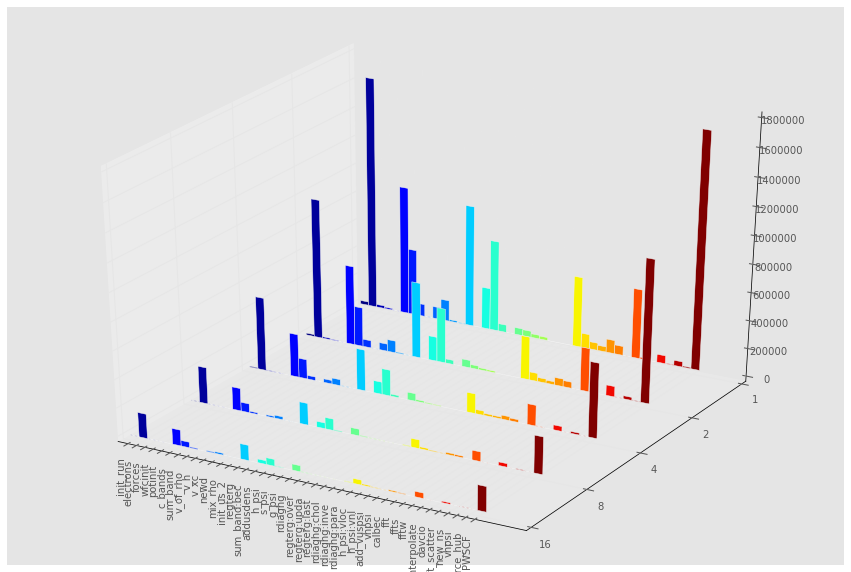

In [120]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
left = [ i for i in np.arange(2*len(experiment8.df)) if i %2 == 0]
print left
cmap = plt.cm.jet
cs=[ cmap(float(i)/max(left)) for i in left]
#ax.bar(left,experiment2.df.cpuTime,zs=1.5,zdir='y',label='cpuTime',color=cs,width=2)

ax.bar(left,exp1_yfill,zs=2,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,exp2_yfill,zs=1.5,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,exp4_yfill,zs=1,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,experiment8.df.cpuTime,zs=0.5,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,experiment16.df.cpuTime,zs=0,zdir='y',label='cpuTime',color=cs,width=2)
#plt.bar()
plt.ylim(0,2)
plt.xticks(np.array(left) + 0.5,experiment16.df.name,rotation=90)
plt.yticks([0,0.5,1,1.5,2],reversed([1,2,4,8,16]))

In [ ]:
getStackedGlobalPlot(datas)

In [ ]:
groupped=datas.groupby('Parent')

In [ ]:
groupped

In [ ]:
groupped.groups

In [ ]:
for name,group in groupped :
    print "name: %s"%name
    print min(group.index),max(group.index)
    